# Packages

In [2]:
# System
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
pd.get_option("display.max_columns")
import numpy as np
from itertools import combinations

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from statsmodels.stats.anova import AnovaRM
from pingouin import ttest

# Preferences
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Functions

In [4]:
# The following three functions make a correlation matrix with scatterplot in lower left, 
# pearson correlation coefficient bubble plot in upper right, and distribution
# plot down the diagonal
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = 1
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.001, cmap="Greys", \
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = 40
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha='center', \
                va='center', fontsize=font_size)

def annotate_colname(x, **kws):
    ax = plt.gca()
    ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes, fontweight='bold')
    
def corr_plot(df):
    sns.set(style='white', font_scale=1.6)
    g = sns.PairGrid(df, aspect=1.4, diag_sharey=False)
    g.map_lower(sns.regplot, scatter_kws={'s':10, 
                                          'color':'k'})
    g.map_diag(sns.distplot, kde_kws={'color': 'black'})
    g.map_diag(annotate_colname)
    g.map_upper(corrdot)
    plt.rcParams["figure.dpi"] = 300
    plt.show()

def theory_cat(df, col):
    cat = []
    for i in range(len(df)):
        if df[col][i]>2:
            categ = 'low'
        else:
            categ = 'high'
        cat.append(str(col+"_"+categ))
    return cat

## Do we see a sign effect in all participants whose data was described well by the hyperbolic discounting equation (i.e., those for whom we can trust the _h_ value we have for them)?

In [6]:
analyses_data = pd.read_excel("../data/second_version/money_only_all_sign_effect.xlsx")
anal_df = analyses_data.copy()
anal_df = anal_df.drop([col for col in list(anal_df) if "Unnamed" in col], axis=1)

# Get unique record ids for demographic dataframe
keep_ids = anal_df['record_id'].unique()

# Transform long-to-wide 
anal_df = anal_df.pivot(index='record_id', columns="task", values=['h']).reset_index()

# Flatten the multiindex cols
anal_df.columns = ["_".join(filter(None, col)).strip() for col in anal_df.columns.values]

# Log the h values
anal_df = np.log(anal_df.iloc[:, 1:])

# PREP FOR EASIER PLOTTING
anal_df.columns = ['Gain Money', 'Lose Money']
anal_df['Gain Money'] = anal_df['Gain Money'].fillna(anal_df['Gain Money'].median())
anal_df['Lose Money'] = anal_df['Lose Money'].fillna(anal_df['Lose Money'].median())

# Where we'll store the results
ttest_disc_df = pd.DataFrame()

# Paired t-tests for monetary outcomes
res = ttest(anal_df['Gain Money'], 
            anal_df['Lose Money'], 
            paired=True, 
            alternative='greater')
res['first_col'] = 'Gain Money'
res['second_col'] = 'Lose Money'
ttest_disc_df = pd.concat([ttest_disc_df, res])
            
ttest_disc_df = ttest_disc_df.reset_index(drop=True)
ttest_disc_df = ttest_disc_df[[ 'first_col', 'second_col', 'T', 'dof',
                                     'alternative', 'p-val', 'CI95%', 'cohen-d',
                                     'BF10', 'power']]
# Take a look
ttest_disc_df # Expect 

,first_col,second_col,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
0,Gain Money,Lose Money,1.891551,65,greater,0.031504,"[0.03, inf]",0.324651,1.443,0.83273


## Let's look at those who met inclusion for all four tasks now

In [8]:
data = pd.read_csv("../data/second_version/discounting_fits_for_included.csv")
df = data.copy()
df.sample(5)

,record_id,race,education,income,utilitarian_rank,deontology_rank,virtue_rank,ethics_care_rank,contract_theory_rank,h_ethics_gains,h_ethics_loss,h_money_gains,h_money_loss,vac_ethics_gains,vac_ethics_loss,vac_money_gains,vac_money_loss,auc_ethics_gains,auc_ethics_loss,auc_money_gains,auc_money_loss
2,P3,White or Caucasian,Bachelor's degree,"Less than $25,000",1.0,5.0,2.0,4.0,3.0,0.439177,0.401311,1.726241,2.409907,0.910119,0.980965,0.909275,0.357966,0.2128,0.3735,0.2489,0.2659
21,P22,White or Caucasian,Bachelor's degree,"$50,000-$74,999",2.0,6.0,3.0,5.0,4.0,0.007305,0.395132,0.415321,2.417497,-0.117241,0.886837,0.469756,0.611080,0.4399,0.4509,0.4580,0.2741
38,P39,"White or Caucasian,Asian",High school diploma or GED,"$50,000-$74,999",2.0,1.0,4.0,5.0,3.0,0.498742,0.215344,1.228796,0.803904,0.936839,0.597437,0.180180,0.991469,0.1803,0.5452,0.2601,0.3134
6,P7,White or Caucasian,"Graduate or professional degree (MA, MS, MBA, ...","$100,000-$149,999",1.0,5.0,2.0,3.0,4.0,0.006646,0.656395,2.937612,1.279788,0.851077,0.967572,0.846343,0.847935,0.4714,0.3514,0.2342,0.2108
29,P30,White or Caucasian,"Some college, but no degree","$25,000-$49,999",1.0,2.0,4.0,5.0,3.0,0.129115,1.630009,2.069407,4.283930,0.923472,0.958706,-1.586266,0.885837,0.3322,0.2158,0.2954,0.1697


In [9]:
# Log h values for their analytics below
for col in [col for col in list(df) if "h_" in col]:
    df[col] = np.log(df[col])

# Demographics information

In [11]:
for col in ['race', 'education', 'income']:
    temp_df = data[col].value_counts().reset_index()
    temp_df['percentage'] = (temp_df['count']/temp_df['count'].sum())*100
    print(col, temp_df, "\n\n")

race                                            race  count  percentage
0                            White or Caucasian     27   69.230769
1                                         Asian      5   12.820513
2  White or Caucasian,Black or African American      3    7.692308
3                     Black or African American      2    5.128205
4                                         Other      1    2.564103
5                      White or Caucasian,Asian      1    2.564103 


education                                            education  count  percentage
0                                  Bachelor's degree     15   38.461538
1                        Some college, but no degree     10   25.641026
2  Graduate or professional degree (MA, MS, MBA, ...      6   15.384615
3                     Associates or technical degree      5   12.820513
4                         High school diploma or GED      3    7.692308 


income               income  count  percentage
0    $75,000-$99,999      8   2

In [12]:
# Create a dataframe with just the discounting data
disc_df = df[[col for col in list(df) if "h_" in col or "vac_" in col]]
disc_df.columns = [
    'Comply Ethics', 
    'Violate Ethics', 
    'Gain Money', 
    'Lose Money', 
    'VAC_CE', # Comply Ethics
    'VAC_VE', # Violate Ethics
    'VAC_MG', # Monetary Gain
    'VAC_ML',  # Monetary Loss
]
disc_df.head()

,Comply Ethics,Violate Ethics,Gain Money,Lose Money,VAC_CE,VAC_VE,VAC_MG,VAC_ML
0,-2.072392,-0.537974,1.501141,1.807013,0.892631,0.841791,0.872606,0.507392
1,-2.784749,-0.409120,0.845568,2.186963,0.952220,0.791991,0.768435,-0.986189
2,-0.822853,-0.913019,0.545946,0.879588,0.910119,0.980965,0.909275,0.357966
3,-1.790205,-0.763310,-1.284233,-0.245791,0.800686,0.908935,0.965459,0.852831
4,-0.008969,-3.399935,1.608558,-1.738384,0.916747,0.494098,0.062043,0.317498


In [13]:
# PREP FOR PLOTTING
disc_df_long = disc_df.iloc[:, :4]
disc_df_long = disc_df_long[(disc_df_long['Gain Money']>=-0.5) & (disc_df_long['Lose Money']<=2)] # Remove outliers
disc_df_long['p_id'] = list(range(1, len(disc_df_long)+1))

# Turn from wide to long
disc_df_long = disc_df_long.melt(id_vars=['p_id'])

# Show a random sample
disc_df_long.sample(5)

,p_id,variable,value
41,10,Violate Ethics,-1.309612
29,30,Comply Ethics,-0.790753
117,22,Lose Money,-0.546955
20,21,Comply Ethics,-1.376783
61,30,Violate Ethics,0.326568


## Figure 1

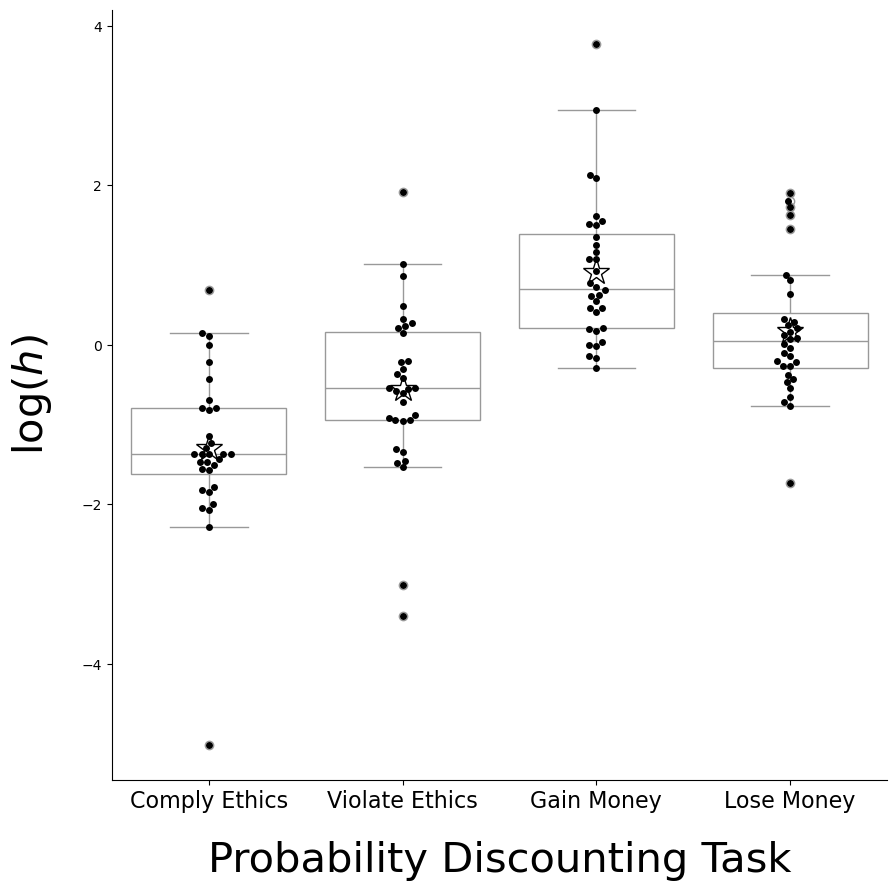

In [15]:
# Boxplot
fig, ax = plt.subplots(figsize=(10, 10))
sns.swarmplot(x='variable', y='value', data=disc_df_long, color='k')
sns.boxplot(x='variable', y='value', data=disc_df_long, color='w', 
            showmeans=True, meanprops={"marker":"*",
                                       "markerfacecolor":"w", 
                                       "markeredgecolor":"black",
                                       "markersize":"20"})
plt.ylabel(r"$\log(h)$", fontsize=30, labelpad=20)
plt.xlabel("Probability Discounting Task", fontsize=30, labelpad=20)
plt.xticks(fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams["figure.dpi"] = 300
plt.show()

In [16]:
# Repeated measures ANOVA
model = AnovaRM(
    data=disc_df_long, 
    depvar='value', 
    subject='p_id', 
    within=['variable']
)
res = model.fit()
res.summary()

,F Value,Num DF,Den DF,Pr > F
variable,34.6920,3.0000,93.0000,0.0000


In [17]:
# Save the results
ttest_disc_df = pd.DataFrame()

# Comparisons for expected direction
compare_cols = [
    ['Comply Ethics', 'Violate Ethics'], 
    ['Comply Ethics', 'Gain Money'], 
    ['Violate Ethics', 'Lose Money']
]

# Paired t-tests
for cols in compare_cols:
    res = ttest(disc_df[cols[0]], 
                disc_df[cols[1]], 
                paired=True, 
                alternative='less')
    res['first_col'] = cols[0]
    res['second_col'] = cols[1]
    ttest_disc_df = pd.concat([ttest_disc_df, res])
            
ttest_disc_df = ttest_disc_df.reset_index(drop=True)
ttest_disc_df = ttest_disc_df[[ 'first_col', 'second_col', 'T', 'dof',
                                     'alternative', 'p-val', 'CI95%', 'cohen-d',
                                     'BF10', 'power']]
ttest_disc_df

,first_col,second_col,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
0,Comply Ethics,Violate Ethics,-3.139927,38,less,1.632317e-03,"[-inf, -0.38]",0.767034,21.66,0.998885
1,Comply Ethics,Gain Money,-8.473396,38,less,1.378436e-10,"[-inf, -1.62]",1.750474,7.74e+07,1.000000
2,Violate Ethics,Lose Money,-5.182054,38,less,3.754121e-06,"[-inf, -0.66]",0.955324,5261.515,0.999987


## Figure 2

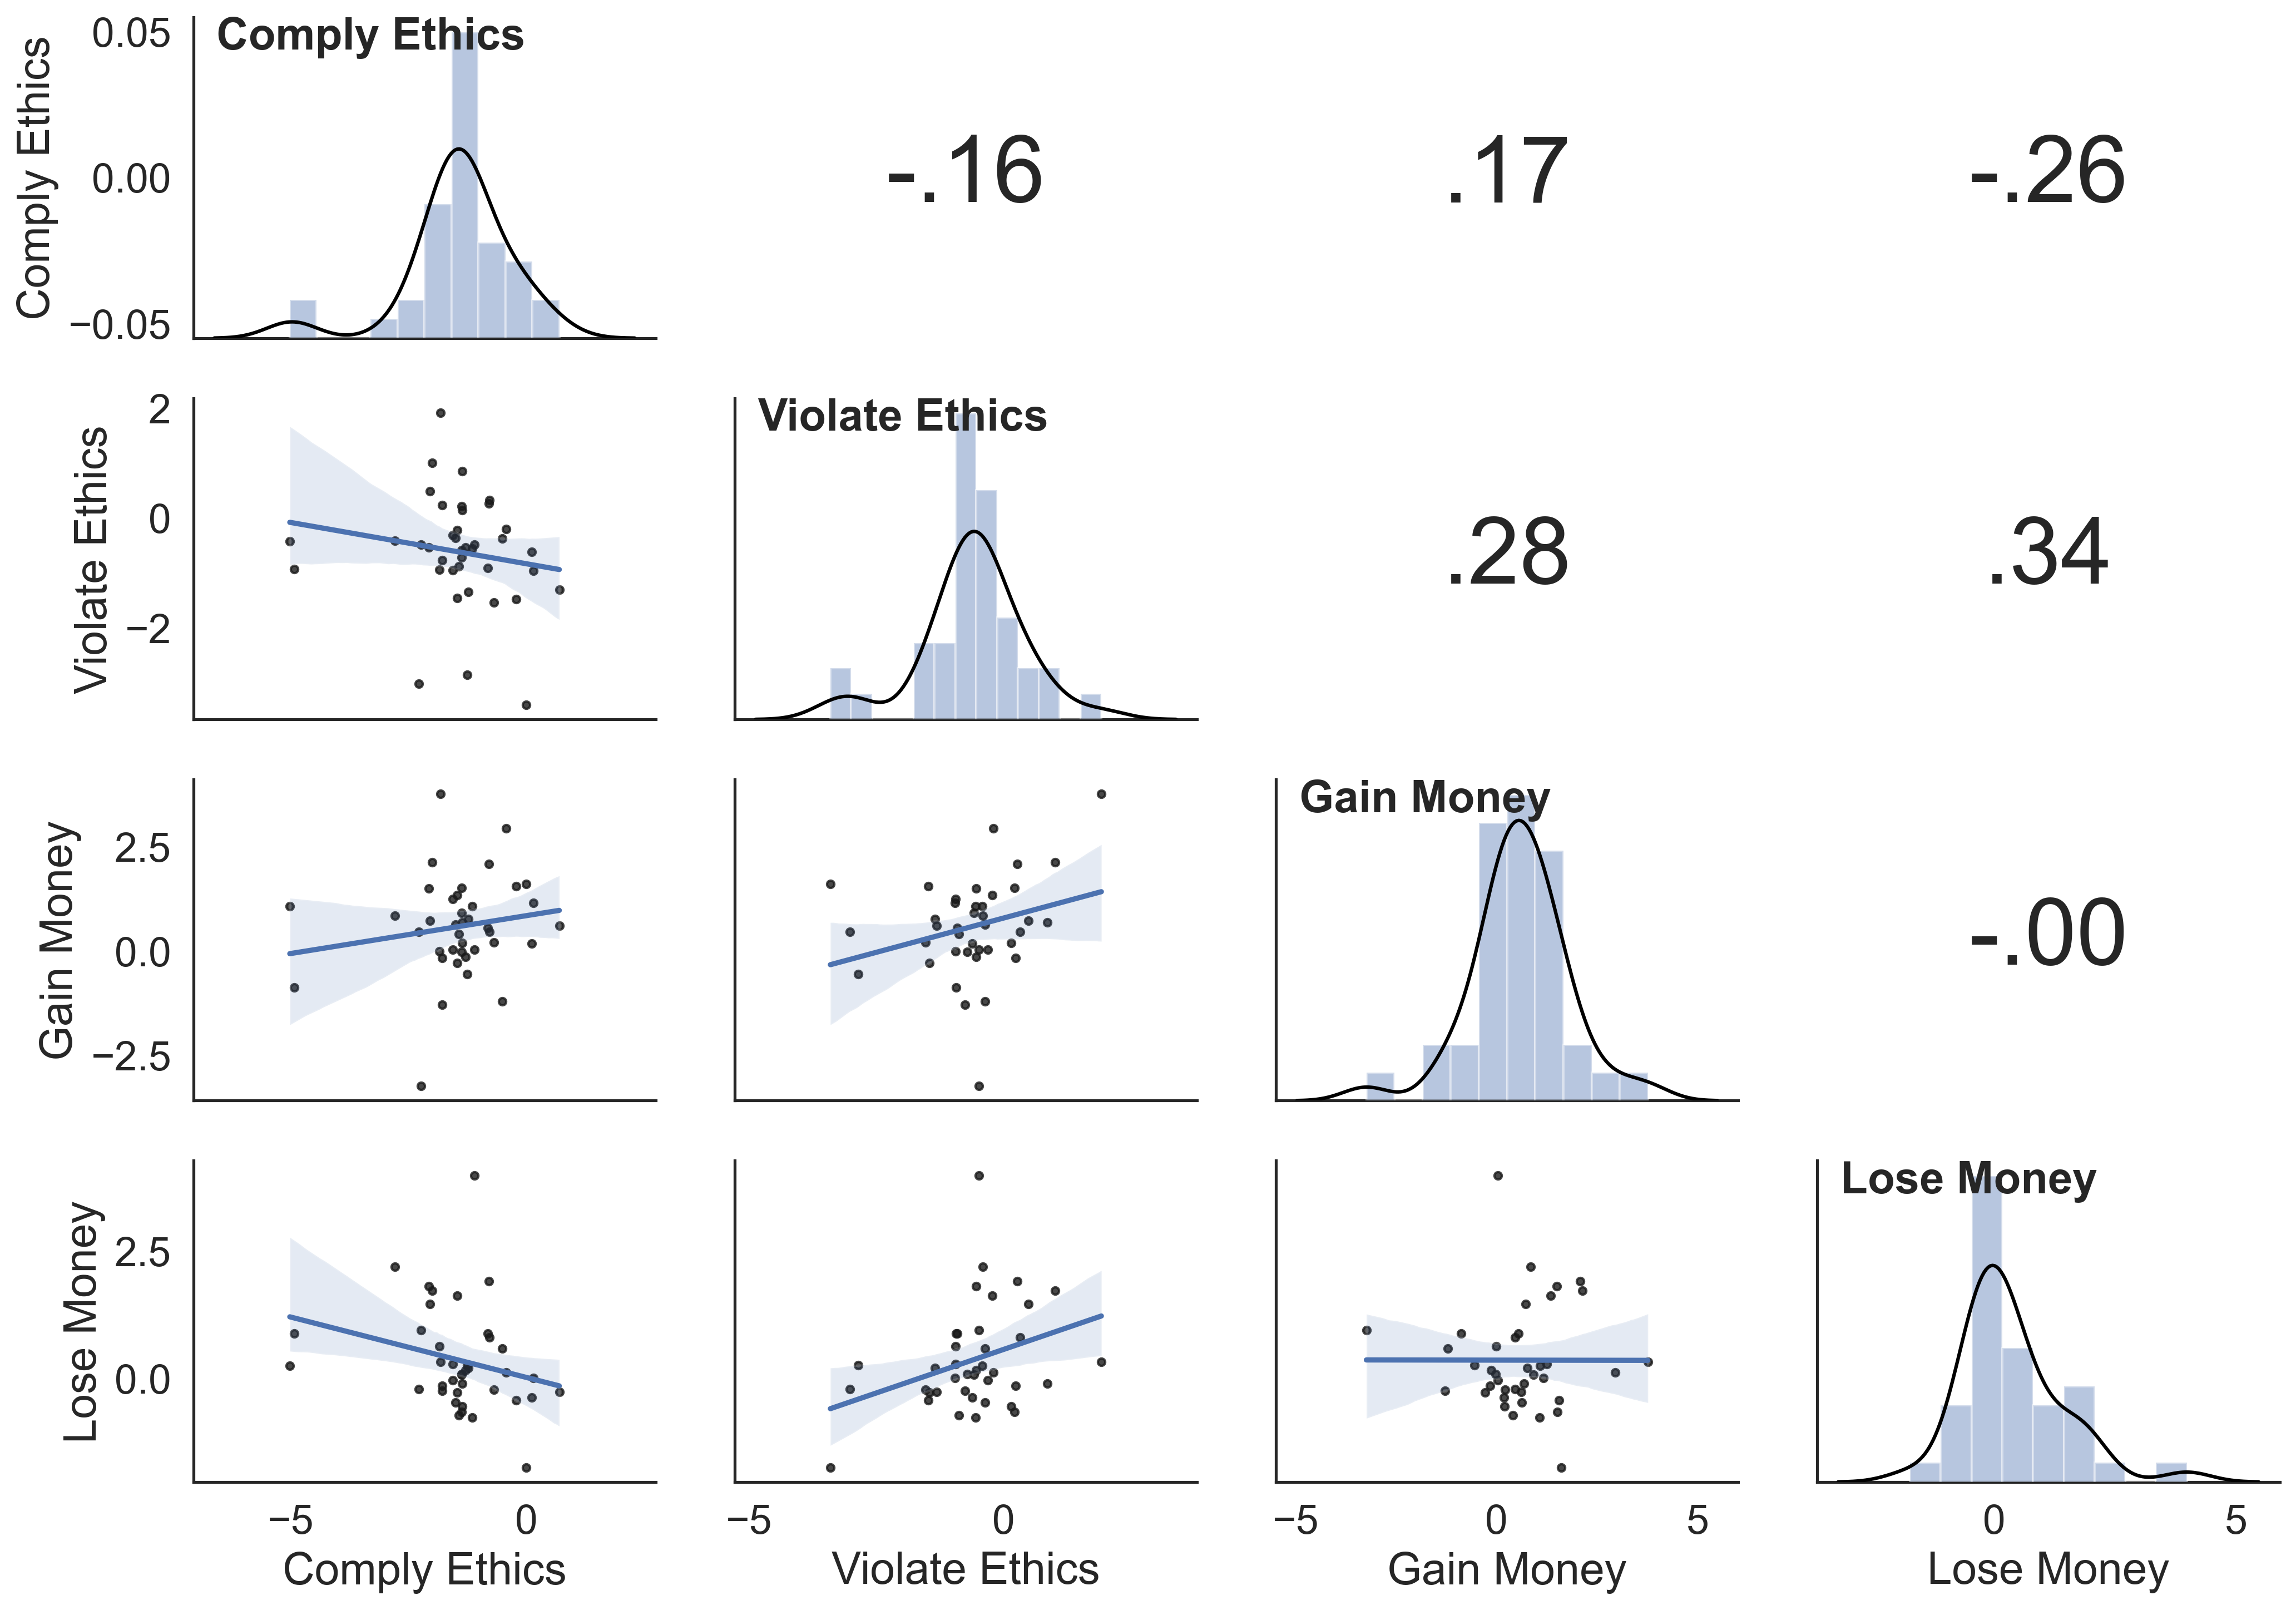

In [19]:
# Correlation matrix
corr_plot(disc_df.iloc[:, :4])

# Ethics Theory Ranking

In [21]:
theor_df = df[['utilitarian_rank', 'deontology_rank', 'virtue_rank', 'ethics_care_rank', 'contract_theory_rank']].dropna().reset_index(drop=True)
theor_df.sample(5)

,utilitarian_rank,deontology_rank,virtue_rank,ethics_care_rank,contract_theory_rank
28,1.0,2.0,4.0,5.0,3.0
14,4.0,5.0,1.0,6.0,7.0
16,5.0,7.0,3.0,9.0,8.0
2,1.0,5.0,2.0,4.0,3.0
25,5.0,1.0,2.0,3.0,4.0


In [22]:
# Where we'll store the results
ttest_theor_df = pd.DataFrame()
theor_df = theor_df.astype(float)

# Paired t-tests for unique column pairs
for col_1, col_2 in combinations(theor_df.columns, 2):
    res = ttest(theor_df[col_1], 
                theor_df[col_2], 
                paired=True, 
                alternative='two-sided')
    res['first_col'] = col_1
    res['second_col'] = col_2
    ttest_theor_df = pd.concat([ttest_theor_df, res])
    
ttest_theor_df = ttest_theor_df.reset_index(drop=True)
ttest_theor_df = ttest_theor_df[[ 'first_col', 'second_col', 'T', 'dof',
                                  'alternative', 'p-val', 'CI95%', 'cohen-d',
                                  'BF10', 'power']]
ttest_theor_df

,first_col,second_col,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
0,utilitarian_rank,deontology_rank,-3.895154,37,two-sided,3.964891e-04,"[-2.36, -0.74]",0.960422,70.88,0.999928
1,utilitarian_rank,virtue_rank,-2.411343,37,two-sided,2.097402e-02,"[-1.65, -0.14]",0.633576,2.223,0.967293
2,utilitarian_rank,ethics_care_rank,-9.550707,37,two-sided,1.582087e-11,"[-2.84, -1.85]",1.675750,5.885e+08,NaN
3,utilitarian_rank,contract_theory_rank,-6.226753,37,two-sided,3.098121e-07,"[-2.44, -1.24]",1.204595,5.12e+04,1.000000
4,deontology_rank,virtue_rank,1.546181,37,two-sided,1.305724e-01,"[-0.2, 1.52]",0.384210,0.519,0.635590
5,deontology_rank,ethics_care_rank,-2.281749,37,two-sided,2.835219e-02,"[-1.49, -0.09]",0.464301,1.731,0.795936
6,deontology_rank,contract_theory_rank,-0.842925,37,two-sided,4.046868e-01,"[-0.99, 0.41]",0.159925,0.243,0.160513
7,virtue_rank,ethics_care_rank,-3.882534,37,two-sided,4.113594e-04,"[-2.2, -0.69]",0.960219,68.575,0.999928
8,virtue_rank,contract_theory_rank,-2.551106,37,two-sided,1.500611e-02,"[-1.7, -0.19]",0.581177,2.943,0.936769
9,ethics_care_rank,contract_theory_rank,1.700883,37,two-sided,9.735634e-02,"[-0.1, 1.1]",0.309120,0.648,0.458675


In [23]:
# PREP FOR EASIER PLOTTING
theor_df_long = theor_df.copy()
theor_df_long['p_id'] = list(range(1, len(theor_df)+1))

# Turn from wide to long
theor_df_long = theor_df_long.melt(id_vars=['p_id'])
theor_df_long[::34]

,p_id,variable,value
0,1,utilitarian_rank,2.0
34,35,utilitarian_rank,2.0
68,31,deontology_rank,4.0
102,27,virtue_rank,3.0
136,23,ethics_care_rank,4.0
170,19,contract_theory_rank,3.0


In [24]:
# Repeated measures ANOVA
theor_df_long = theor_df_long.dropna().reset_index(drop=True)
model = AnovaRM(data=theor_df_long, depvar='value', subject='p_id', within=['variable'])
res = model.fit()
res.summary()

,F Value,Num DF,Den DF,Pr > F
variable,13.4335,4.0000,148.0000,0.0000


## Figure 3

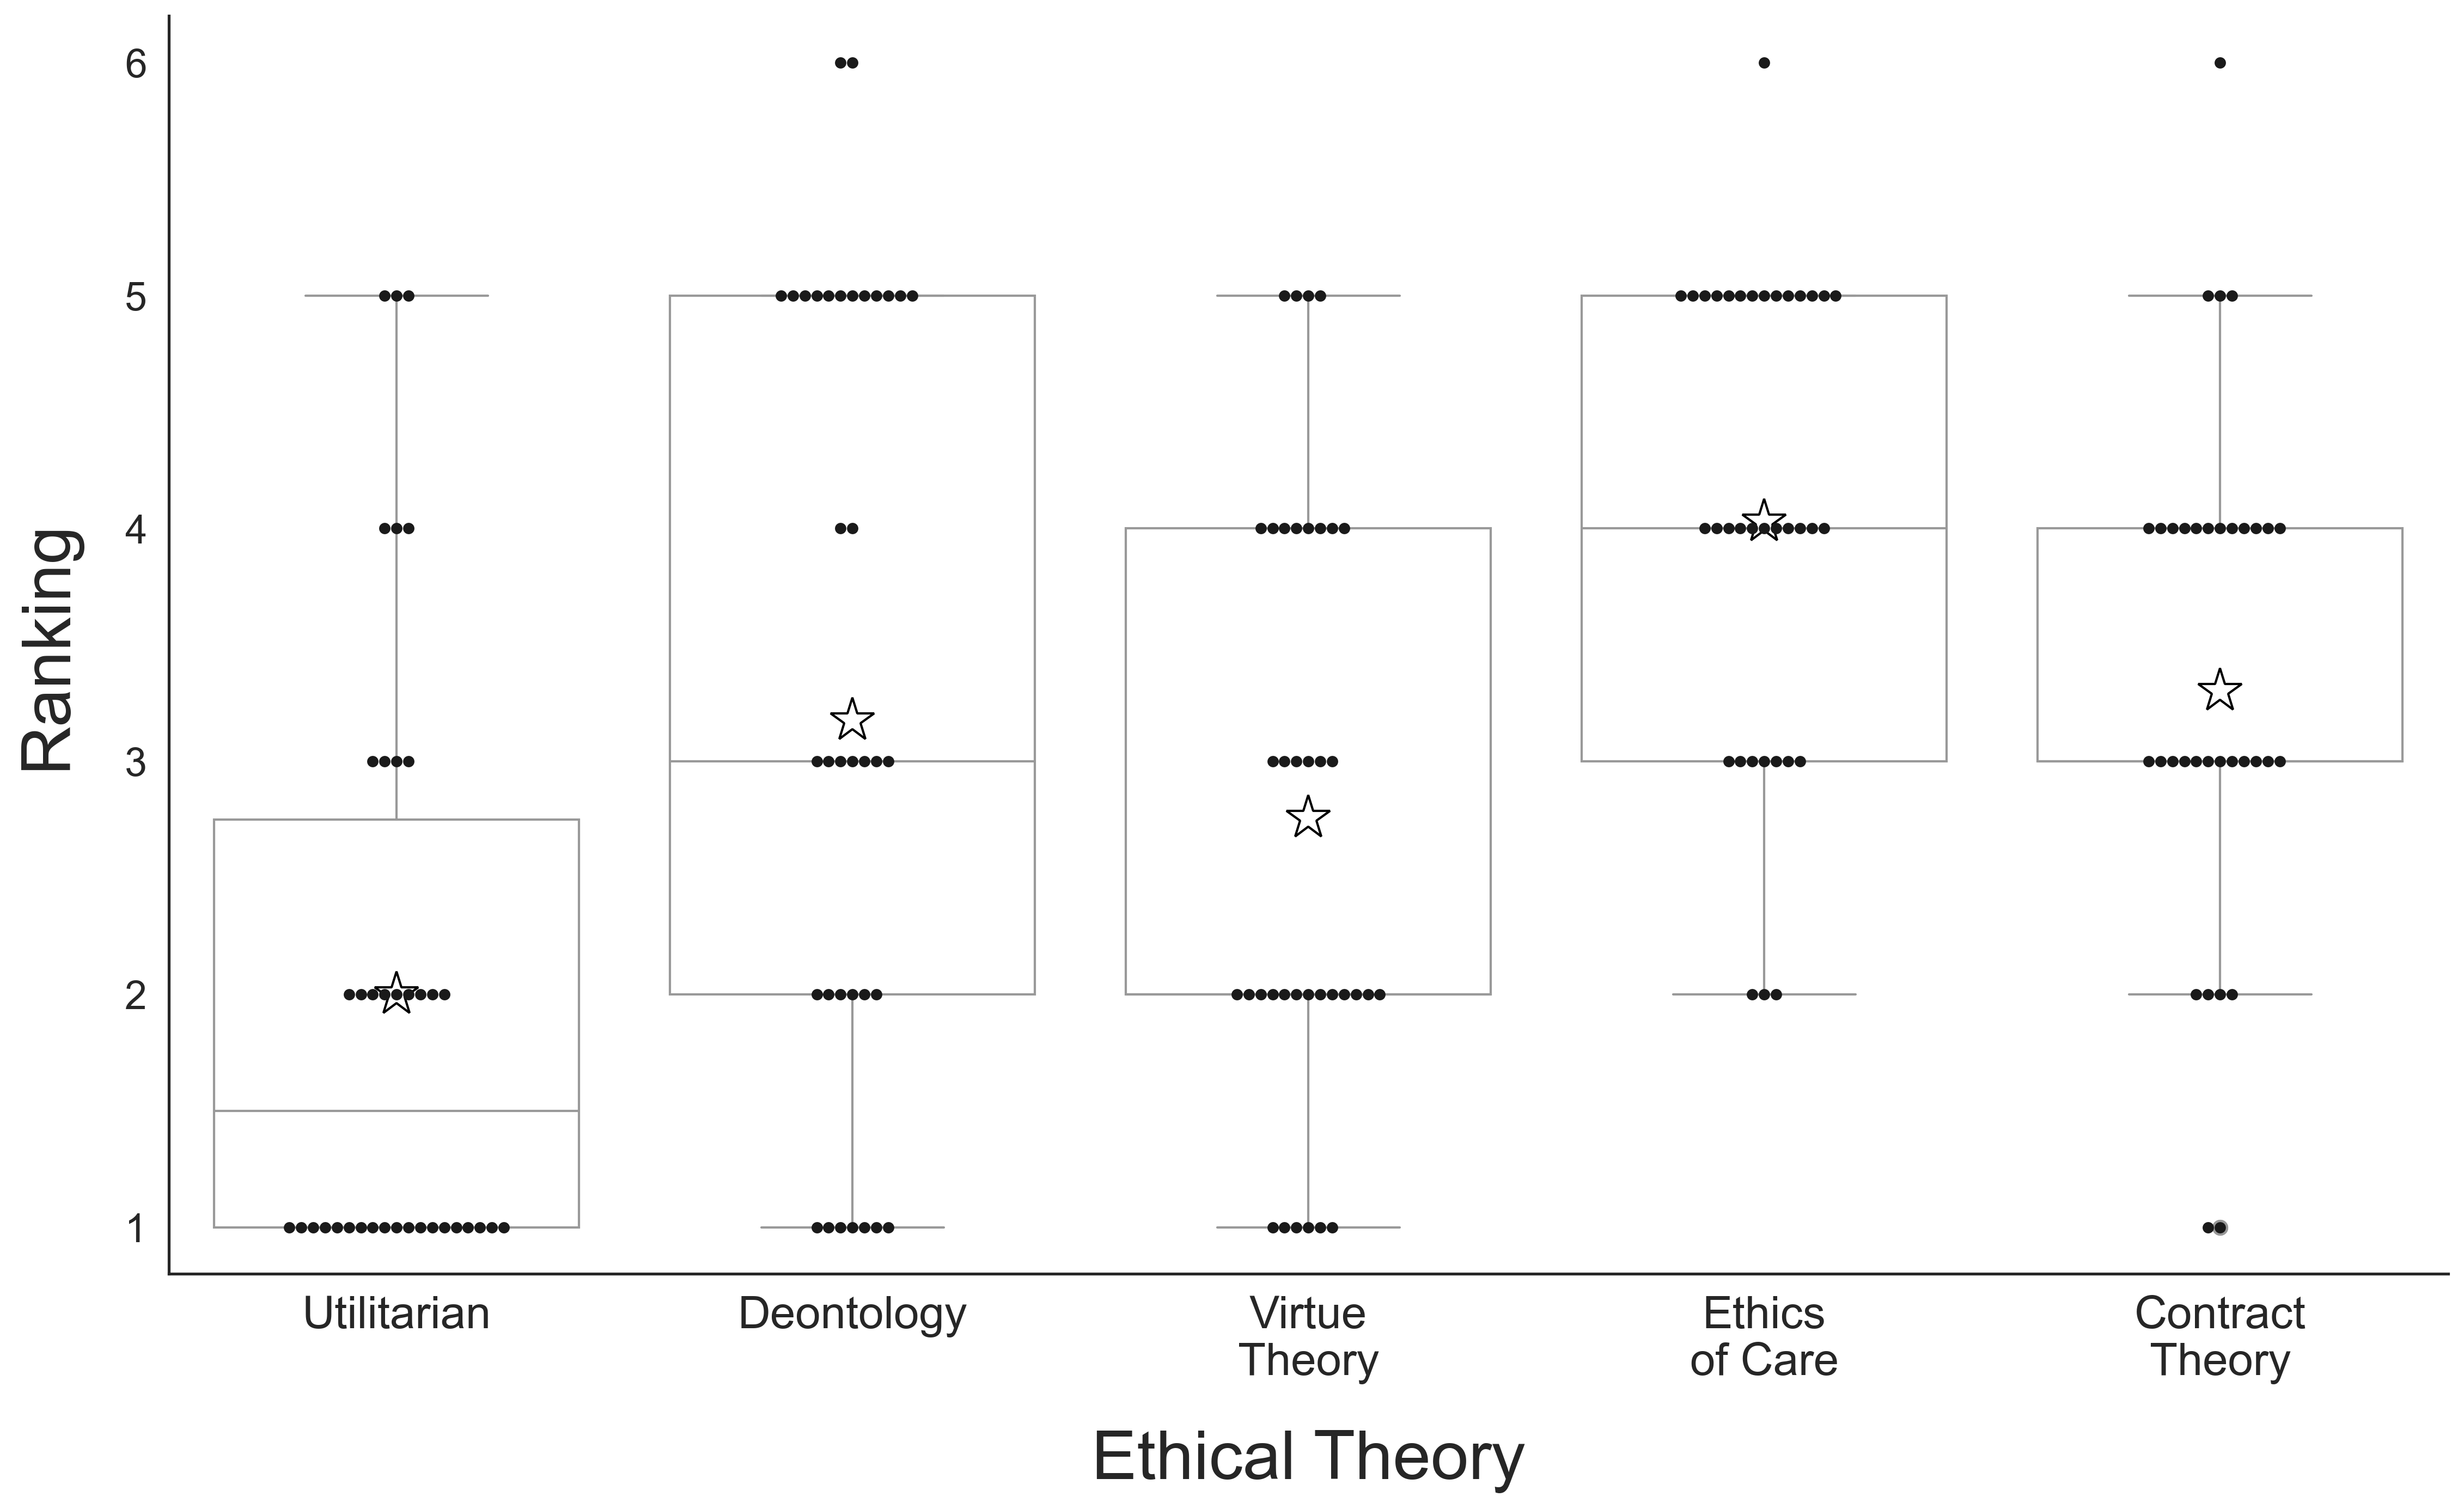

In [26]:
# Boxplot
fig, ax = plt.subplots(figsize=(18, 10))
sns.swarmplot(x='variable', y='value', data=theor_df_long, color='k')
sns.boxplot(x='variable', y='value', data=theor_df_long[theor_df_long['value']<6], color='w', 
           showmeans=True, meanprops={"marker":"*",
                                      "markerfacecolor":"white", 
                                      "markeredgecolor":"black",
                                      "markersize":"20"})
plt.ylabel("Ranking", fontsize=30, labelpad=20)
ticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.yticks(ticks=ticks, labels=ticks)
plt.ylim(0.8, 6.2)
ticks = [0, 1, 2, 3, 4]
labels=["Utilitarian", 'Deontology', 'Virtue\nTheory', 'Ethics\nof Care', 'Contract\nTheory']
plt.xticks(ticks=ticks, labels=labels, fontsize=20)
plt.xlabel("Ethical Theory", fontsize=30, labelpad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams["figure.dpi"] = 300
plt.show()

In [27]:
# Prep df for correlation matrix 
# Ethical Discounting Data
disc_df = df[[col for col in list(df) if "h_" in col]]
disc_df.columns = ['Comply Ethics', 'Violate Ethics', 'Gain Money', 'Lose Money']
disc_df = disc_df.drop(['Gain Money', 'Lose Money'], axis=1)

# Ethical Theory Preference
theor_df = df[['utilitarian_rank', 'deontology_rank', 'virtue_rank', 'ethics_care_rank', 'contract_theory_rank']].dropna().reset_index(drop=True)
theor_df.columns = ['Utilitarian', 'Deontology', 'Virtue Theory', 'Ethics of Care', 'Contract Theory']
theor_df = theor_df.astype(int)

# Merge into single df
plot_df = pd.concat([theor_df, disc_df], axis=1)
plot_df.sample(5)

,Utilitarian,Deontology,Virtue Theory,Ethics of Care,Contract Theory,Comply Ethics,Violate Ethics
17,2.0,1.0,3.0,4.0,5.0,-1.364939,0.856989
1,1.0,2.0,3.0,4.0,5.0,-2.784749,-0.409120
6,1.0,5.0,2.0,3.0,4.0,-5.013703,-0.420992
18,1.0,5.0,2.0,4.0,3.0,-1.821134,1.915684
2,1.0,5.0,2.0,4.0,3.0,-0.822853,-0.913019


## Figure 4

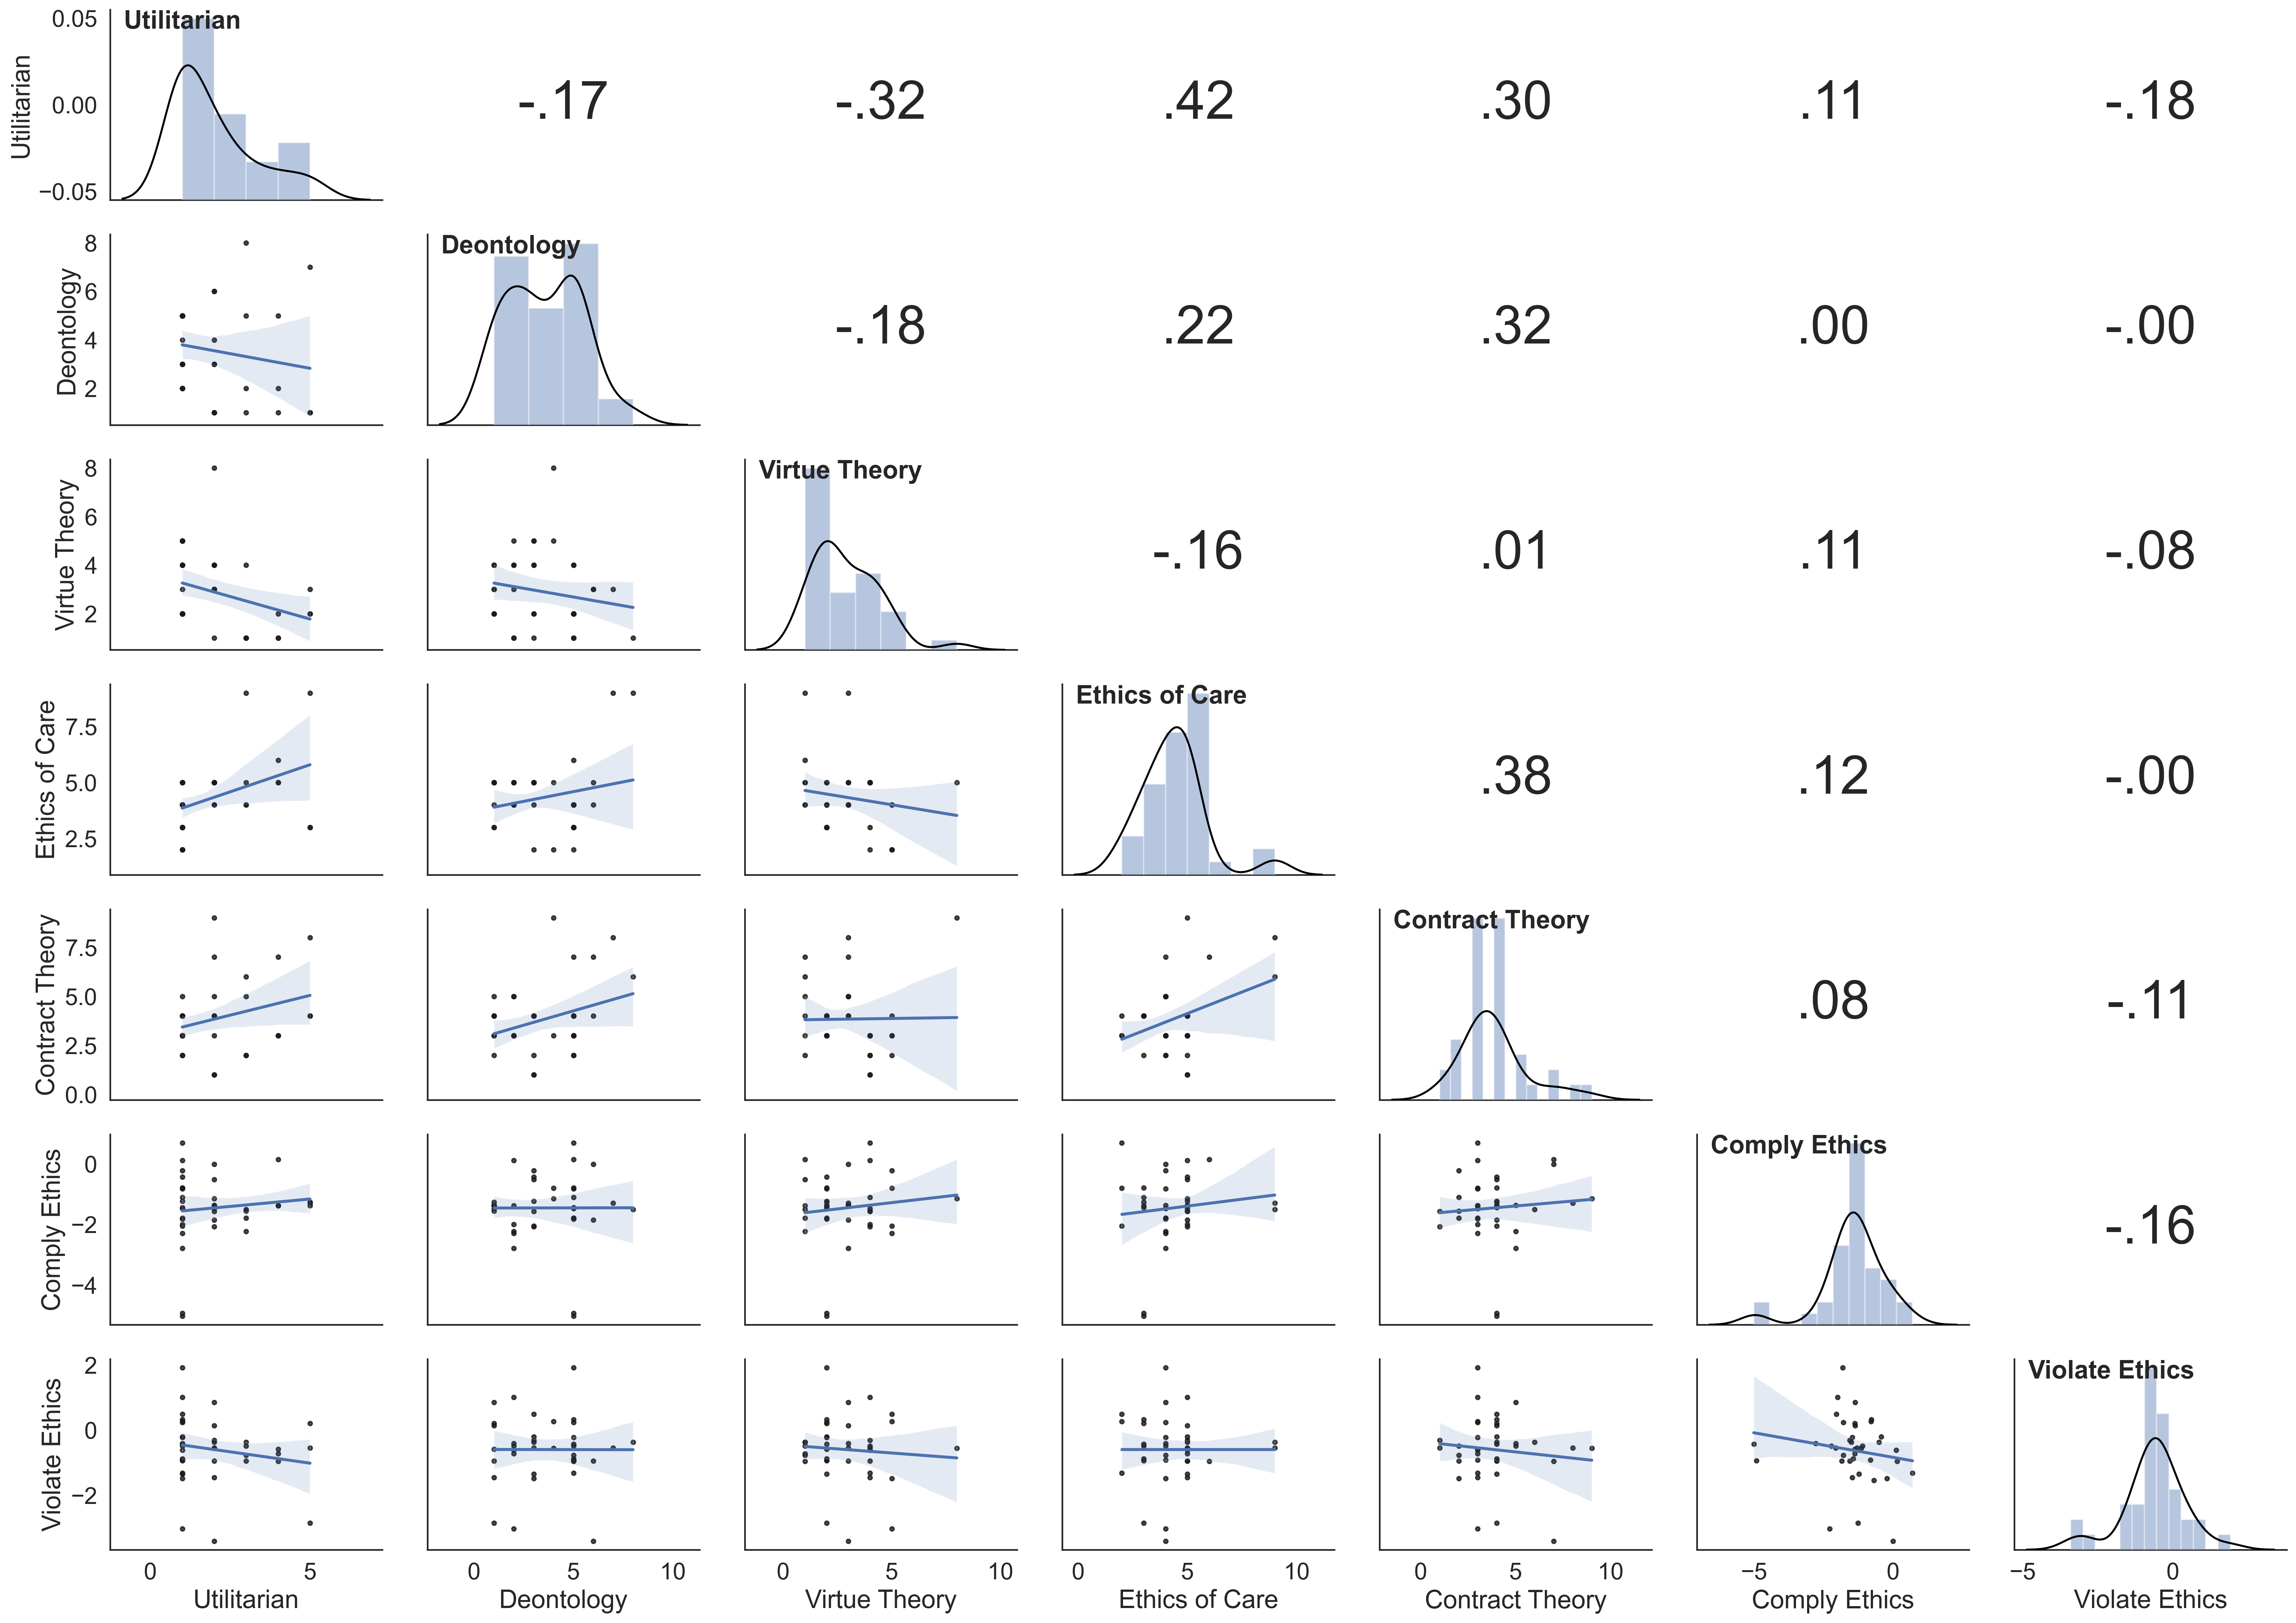

In [29]:
corr_plot(plot_df)